In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit


from causalgraphicalmodels import CausalGraphicalModel
import daft

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [4]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std() 

## Ex. 1

Conduct a prior predictive simulation for the Reedfrog model.
How does increasing the width of the prior on σ change the prior distribution of αj? You might try Exponential(10) and Exponential(0.1) for example

In [5]:
df = pd.read_csv('data/reedfrogs.csv', sep=',')
print(df.shape)
df.head()

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [6]:
tank = np.arange(df.shape[0])
n_tanks = df.shape[0]

In [7]:
# simple model

with pm.Model() as m_6_0:

    a = pm.Normal('a', 0, 1.5, shape=n_tanks)
    p = pm.math.invlogit(a[tank])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    trace_6_0 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Model definition 

\begin{split}\begin{aligned}
S_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha_T[_i] \\
\alpha_j &\sim Normal(\bar{\alpha}, \sigma) \\
\bar{\alpha} &\sim Normal(0, 1.5) \\
\sigma &\sim Exponential(1) \\


\end{aligned}\end{split}




In [8]:
# basic multi-level model
with pm.Model() as m_6_1:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1.0)

    a = pm.Normal('a', a_bar, sigma, shape=n_tanks)
    p = pm.math.invlogit(a[tank])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    trace_6_1 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [9]:
#compare simple and multi-level model
az.compare({"m6_0": trace_6_0, "m6_1": trace_6_1},'waic')


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_1,0,-100.324619,21.085133,0.000000,1.0,3.618523,0.000000,True,log
m6_0,1,-107.030934,25.331602,6.706314,0.0,2.313575,1.799487,True,log


## A) Simulate priors for different sigma values directly from the model

In [10]:
prior_pred_dict = dict()
exp_values = [0.1, 1, 10]
models = ['one', 'two', 'three']
tank = df.index

for x, m in zip(exp_values, models):
    with pm.Model() as m:
        a_bar = pm.Normal("a_bar", 0.0, 1.5)
        sigma = pm.Exponential("sigma", x)

        a = pm.Normal('a', a_bar, sigma, shape=n_tanks)
        p = pm.Deterministic('p', pm.math.invlogit(a[tank]))

        S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
        prior = pm.sample_prior_predictive(1000, var_names=['a'])

        prior_pred_dict[x] = prior


Text(0.5, 1.0, 'prob distribution for different sigma values')

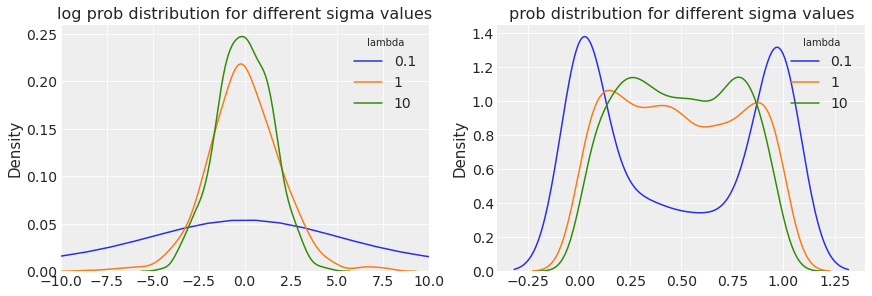

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

for x in exp_values:
    prior_pred_a = prior_pred_dict[x]['a'][:,0]

    sns.kdeplot(prior_pred_a, ax=ax1)
ax1.legend(exp_values, title='lambda') 
ax1.set(title='log prob distribution for different sigma values', xlim=(-10, 10))

for x in exp_values:
    sns.kdeplot(expit(prior_pred_dict[x]['a'][:,0]), ax=ax2)
ax2.legend(exp_values, title='lambda')

ax2.set_title('prob distribution for different sigma values')

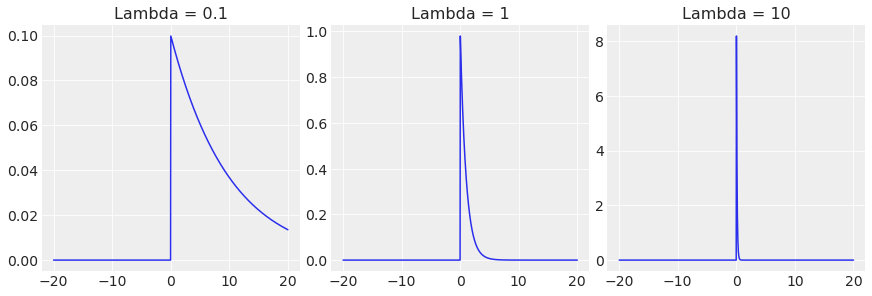

In [12]:
#check shape of exponential priors on sigma

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

exp_values = [0.1, 1, 10]
axes = [ax1, ax2, ax3]
x = np.linspace(-20, 20, 1000)
for ax, exp in zip(axes, exp_values):
    y = stats.expon.pdf(x, scale=1/exp)
    ax.plot(x, y)
    ax.set(title= 'Lambda = {}'.format(exp))



The higher the lambda value, the more the distribution is concentrated near zero.

## B) Simulate priors manually to double-check

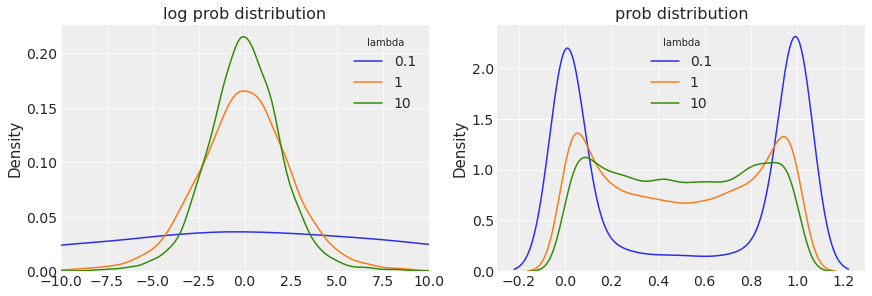

In [13]:
exp_values = [0.1, 1, 10]
n = 10000

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for x in exp_values:
    a_bar = stats.norm.rvs(0, 1.5, size=n)
    sigma = stats.expon.rvs(1/x, size=n)

    a = stats.norm.rvs(a_bar, sigma, size=n)
    sns.kdeplot(a, ax=ax1, label=f'{x}')

    sns.kdeplot(expit(a), ax=ax2, label=f'{x}')

ax1.set(title='log prob distribution', xlim=(-10, 10))
ax1.legend(title='lambda')

ax2.set(title='prob distribution')

ax2.legend(title='lambda')


Conclusion: small lambda parameters lead to almost uniform distributions on the log probability scale. When transformed to probability, such a wide distribution leads to most of probability being concentrated on the extreme ends, suggesting that either extermely low or extremely high probability is most probable. This is not the desired behaviour, therefore lambda values of 1 or 10 are much more suitable as a prior for sigma.

# Ex. 2

Revisit the Reedfrog survival data, data(reedfrogs). 
- Start with the varying effects model from the book and lecture. 
- Then modify it to estimate the causal effects of the treatment variables pred and size, including how size might modify the effect of predation. 

An easy approach is to estimate an effect for each combination of pred and size. Justify your model with a DAG of this experiment.

Varying effects model definition 

\begin{split}\begin{aligned}
S_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha_T[_i] \\
\alpha_j &\sim Normal(\bar{\alpha}, \sigma) \\
\bar{\alpha} &\sim Normal(0, 1.5) \\
\sigma &\sim Exponential(1) \\


\end{aligned}\end{split}


In [49]:
print(df.shape)
df.head()

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [50]:
# basic multi-level model
with pm.Model() as m_6_2:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1.0)

    a = pm.Normal('a', a_bar, sigma, shape=n_tanks)
    p = pm.math.invlogit(a[tank])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    trace_6_2 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [129]:
az.summary(trace_6_2, var_names=['a_bar', 'sigma'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.344,0.255,0.881,1.825,0.004,0.003,5133.0,3463.0,1.0
sigma,1.615,0.213,1.251,2.037,0.004,0.003,3177.0,3303.0,1.0


In [125]:
#extract hdis for each datapoint
hdi_low = []
hdi_high = []
for x in tank:
    y = az.hdi(expit(trace_6_2['a'][:,x]))[0]
    z = az.hdi(expit(trace_6_2['a'][:,x]))[1]
    hdi_low.append(y)
    hdi_high.append(z)



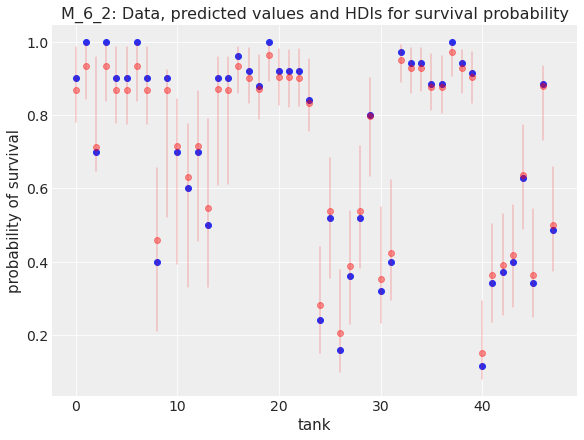

In [155]:
#visualize data and HDIs

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(tank, df.propsurv) #real data

for x in tank:
    ax.scatter(x, expit(trace_6_2['a'][:,x]).mean(), color='r', alpha=0.4) # mean predictions


for x, lower, upper in zip(tank, hdi_low, hdi_high):
    ax.plot((x, x), (lower, upper), color='r', alpha=0.2)

ax.set(title='M_6_2: Data, predicted values and HDIs for survival probability',xlabel='tank',ylabel='probability of survival');

In [120]:
df = df.rename(columns={'size':'size_'})

pred_id = pd.factorize(df.pred)[0]
pred_idx = pd.factorize(df.pred)[1]

size_id = pd.factorize(df.size_)[0]
size_idx = pd.factorize(df.size_)[1]

df.dens_s = standardize(df.density)

In [136]:
len(size_idx)

2

In [137]:
#adding predators and size to the previous model
with pm.Model() as m_6_2b:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1.0)

    b = pm.Normal('b', 0, 0.5, shape=(len(pred_idx), len(size_idx))) # matrix for each combination of predator and size
    a = pm.Normal('a', a_bar, sigma, shape=len(tank))
    
    p = pm.math.invlogit(a[tank] + b[pred_id, size_id])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)

    trace_6_2b = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [138]:
pm.summary(trace_6_2b,round_to=2, var_names=['a_bar', 'b', 'sigma'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.24,0.30,0.65,1.78,0.01,0.01,449.73,665.92,1.01
"b[0, 0]",1.06,0.36,0.38,1.73,0.01,0.01,776.50,1307.07,1.00
"b[0, 1]",0.97,0.35,0.29,1.62,0.01,0.01,751.98,1611.52,1.00
"b[1, 0]",-1.28,0.35,-1.95,-0.65,0.01,0.01,644.04,1222.90,1.00
"b[1, 1]",-0.57,0.34,-1.19,0.08,0.01,0.01,521.31,1125.51,1.01
sigma,0.82,0.16,0.52,1.13,0.01,0.00,878.13,1394.68,1.00


We observe that:
- presence of predators has a strong negative effect on survival probability (due to the low beta parameter value)
- extent of predator effect also depends on the size (predator effect is less negative for smaller tanks)
- adding predators to the model decreased the sigma value (since a substantial part in the variation between the individual tanks can be explained by presence/absence of predators and the size variable)

In [148]:
#visualize
#extract hdis for each datapoint
hdi_low = []
hdi_high = []
for x, p, s in zip(tank, pred_id, size_id):
    y = az.hdi(expit(trace_6_2b['a'][:,x] + trace_6_2b['b'][:,p][:,s]))[0]
    z = az.hdi(expit(trace_6_2b['a'][:,x] + trace_6_2b['b'][:,p][:,s]))[1]
    hdi_low.append(y)
    hdi_high.append(z)

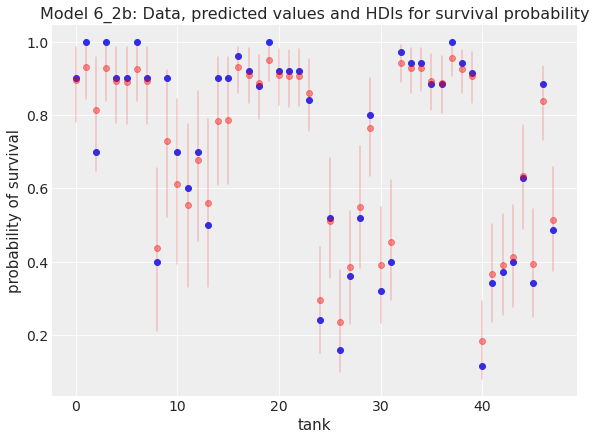

In [151]:
#visualize data and HDIs

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(tank, df.propsurv) #real data

for x, p, s in zip(tank, pred_id, size_id):
    ax.scatter(x, expit(trace_6_2b['a'][:,x] + trace_6_2b['b'][:,p][:,s]).mean(), color='r', alpha=0.4) # mean predictions


for x, lower, upper in zip(tank, hdi_low, hdi_high):
    ax.plot((x, x), (lower, upper), color='r', alpha=0.2)

ax.set(title='Model 6_2b: Data, predicted values and HDIs for survival probability',xlabel='tank',ylabel='probability of survival');

In [152]:
az.compare({"m6_2": trace_6_2, "m6_2b": trace_6_2b},'waic')


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_2b,0,-99.496086,19.055211,0.000000,0.58705,4.144502,0.000000,True,log
m6_2,1,-99.702422,20.633588,0.206336,0.41295,3.613268,2.359026,True,log


# Ex. 3

Now estimate the causal effect of density on survival. Consider whether pred modifies the effect of density. There are several good ways to include density in your Binomial GLM. You could treat it as a continuous regression variable (possibly standardized). Or you could convert it to an ordered category (with three levels). Compare the σ (tank standard deviation) posterior distribution to σ from your model in Problem 2. How are they different? Why?

In [156]:
#adding density to the varying effects model
with pm.Model() as m_6_3:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1.0)

    b = pm.Normal('b', 0, 0.5)
    
    a = pm.Normal('a', a_bar, sigma, shape=len(tank))
    
    p = pm.math.invlogit(a[tank] + b*df.dens_s)

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)

    trace_6_3 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [182]:
pm.summary(trace_6_3,round_to=2, var_names=['a_bar', 'b','sigma'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.36,0.26,0.86,1.84,0.00,0.00,3880.47,2990.18,1.0
b,-0.21,0.23,-0.64,0.24,0.01,0.01,713.21,1250.81,1.0
sigma,1.62,0.22,1.22,2.01,0.00,0.00,2485.10,2915.42,1.0


In [178]:
#adding density and predators as additive terms to the varying effects model

with pm.Model() as m_6_3b:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1.0)

    b_P = pm.Normal('b_P', 0, 0.5,shape=len(pred_idx))
    b_D = pm.Normal('b_D', 0, 0.5)

    a = pm.Normal('a', a_bar, sigma, shape=len(tank))
    
    p = pm.math.invlogit(a[tank] + b_P[pred_id] + b_D*df.dens_s)

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)

    trace_6_3b = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_D, b_P, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [183]:
az.summary(trace_6_3b, var_names=['a_bar','b_P','b_D', 'sigma'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.288,0.394,0.552,1.996,0.022,0.016,326.0,594.0,1.01
b_P[0],1.190,0.394,0.386,1.860,0.020,0.014,402.0,756.0,1.01
b_P[1],-1.064,0.395,-1.775,-0.336,0.021,0.015,356.0,755.0,1.01
b_D,-0.228,0.157,-0.534,0.061,0.004,0.002,1977.0,1737.0,1.00
sigma,0.815,0.146,0.523,1.061,0.004,0.003,1105.0,1505.0,1.00


In [186]:
#compare sigma (tank standard deviation) for problems 2 and 3

traces = [trace_6_2, trace_6_2b, trace_6_3, trace_6_3b]
labels = ["varying effects", "pred and size (interactive)", "density", "pred and density (additive)"]

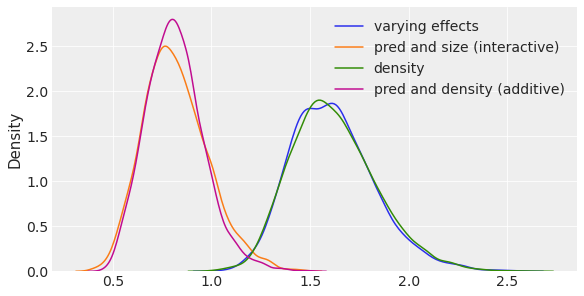

In [187]:
fig, ax = plt.subplots(figsize=(8,4))

for i, trace in enumerate(traces):
    sigma = trace['sigma']
    sns.kdeplot(sigma,ax=ax, label=labels[i])

ax.legend()    

Conclusion: 
Density does not explain the variation in tanks as well as presence of predator does.

In [188]:
az.compare({'6_2': trace_6_2, '6_2b': trace_6_2b, '6_3':trace_6_3, '6_3b':trace_6_3b},'waic')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
6_3b,0,-99.174052,18.946984,0.000000,0.622519,4.540410,0.000000,True,log
6_2b,1,-99.496086,19.055211,0.322034,0.000000,4.144502,1.637061,True,log
6_2,2,-99.702422,20.633588,0.528370,0.377481,3.613268,2.681481,True,log
6_3,3,-100.097415,21.008868,0.923363,0.000000,3.731240,2.623804,True,log
